In [1]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
nltk.download('punkt')
import torch
from glob import glob

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
model_name = "facebook/bart-large-mnli"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device,
    )
    return theme_classifier

In [3]:
theme_classifier = load_model(device)

Device set to use cpu


In [4]:
theme_list = ["physics", "chemistry", "biology", "mathematics", "history", "geography", "literature", "art", "music", "sports"]
theme_classifier("If we pour KmnO4 solution into a solution of NaCl, a redox reaction occurs. The KMnO4 solution is purple in color and the NaCl solution is colorless. The KMnO4 solution is used as an oxidizing agent in this reaction.",
                 theme_list,
                 multi_label=True
    )

{'sequence': 'If we pour KmnO4 solution into a solution of NaCl, a redox reaction occurs. The KMnO4 solution is purple in color and the NaCl solution is colorless. The KMnO4 solution is used as an oxidizing agent in this reaction.',
 'labels': ['chemistry',
  'physics',
  'art',
  'biology',
  'literature',
  'sports',
  'geography',
  'mathematics',
  'music',
  'history'],
 'scores': [0.989816427230835,
  0.35277464985847473,
  0.07541731745004654,
  0.038523685187101364,
  0.013527500443160534,
  0.008456285111606121,
  0.005953287240117788,
  0.005521595478057861,
  0.004393058363348246,
  0.001631166902370751]}

In [5]:
!pip install pandas
import pandas as pd

In [6]:
def load_subtitles_dataset(dataset_path):
    subtitles_path = glob(dataset_path+"/*.ass")
    scripts=[]
    episode_num=[]
    for path in subtitles_path:
        with open(path,'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines = [",".join(line.split(",")[9:]) for line in lines]
        lines = [ line.replace("\\N"," ") for line in lines]
        script = " ".join(lines)
        episode = int(path.split("-")[-1].split(".")[0].strip())
        scripts.append(script)
        episode_num.append(episode)
    df = pd.DataFrame({"episode": episode_num, "script": scripts})
    return df

dataset_path = "../data/Subtitles"
df = load_subtitles_dataset(dataset_path)
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


In [7]:
script = df.iloc[0]['script']
script_sentences = sent_tokenize(script)
script_sentences[:3]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [8]:
script_batch_size=20
script_batches=[]
for i in range(0, len(script_sentences), script_batch_size):
    sent=" ".join(script_sentences[i:i+script_batch_size])
    script_batches.append(sent)
script_batches[:3]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [9]:
theme_list= ["dialogue","betrayal","sacrifice","self developement","hope","friendship","love","battle"]
theme_output = theme_classifier(
    script_batches[0:3],
    theme_list,
    multi_label=True
)
theme_output 

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'sacrifice',
   'self developement',
   'hope',
   'friendship',
   'love'],
  'scores': [0.9800741672515869,
   0.939690351486206,
   0.8546885251998901,
   0.7349815964698792,
   0.6545649170875549,
   0.199098199605941

In [10]:
themes ={}
for output in theme_output:
    for label,score in zip(output['labels'],output['scores']):
        if label not in themes:
            themes[label]=[]
        themes[label].append(score)
themes

{'dialogue': [0.9800741672515869, 0.9370126724243164, 0.9554803371429443],
 'betrayal': [0.939690351486206, 0.6457260847091675, 0.734232485294342],
 'battle': [0.8546885251998901, 0.6581321954727173, 0.7520479559898376],
 'sacrifice': [0.7349815964698792, 0.6258837580680847, 0.5151649117469788],
 'self developement': [0.6545649170875549,
  0.8029875159263611,
  0.6884000897407532],
 'hope': [0.19909819960594177, 0.2042398601770401, 0.5138541460037231],
 'friendship': [0.05922342836856842, 0.08603370934724808, 0.3491247892379761],
 'love': [0.040261901915073395, 0.02802049182355404, 0.19979576766490936]}

In [11]:
import numpy as np
themes = {key: np.mean(np.array(value)) for key,value in themes.items()}
themes

{'dialogue': 0.9575223922729492,
 'betrayal': 0.7732163071632385,
 'battle': 0.7549562255541483,
 'sacrifice': 0.6253434220949808,
 'self developement': 0.7153175075848898,
 'hope': 0.305730735262235,
 'friendship': 0.1647939756512642,
 'love': 0.08935938713451226}

In [12]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)
    script_batch_size=20
    script_batches=[]
    for i in range(0, len(script_sentences), script_batch_size):
        sent=" ".join(script_sentences[i:i+script_batch_size])
        script_batches.append(sent)
    theme_output = theme_classifier(
        script_batches,
        theme_list,
        multi_label=True
    )
    themes ={}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label]=[]
            themes[label].append(score)
    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}
    return themes

In [14]:
df_temp = df[:2]
df_temp
output_themes = df_temp["script"].apply(get_themes_inference)

In [15]:
output_themes
theme_df = pd.DataFrame(output_themes.tolist())
theme_df

,dialogue,betrayal,battle,sacrifice,self developement,hope,friendship,love
0,0.933066,0.843437,0.730704,0.738852,0.738627,0.356776,0.270747,0.171008
1,0.878907,0.523089,0.614092,0.560679,0.666437,0.360577,0.199374,0.126210


In [16]:
df_temp[theme_df.columns] = theme_df
df_temp

C:\Users\Asus\AppData\Local\Temp\ipykernel_16072\2183799632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[theme_df.columns] = theme_df
C:\Users\Asus\AppData\Local\Temp\ipykernel_16072\2183799632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[theme_df.columns] = theme_df
C:\Users\Asus\AppData\Local\Temp\ipykernel_16072\2183799632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,episode,script,dialogue,betrayal,battle,sacrifice,self developement,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.933066,0.843437,0.730704,0.738852,0.738627,0.356776,0.270747,0.171008
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.878907,0.523089,0.614092,0.560679,0.666437,0.360577,0.199374,0.126210


In [27]:
theme_out=df_temp.drop(['dialogue','episode','script'], axis=1).sum().reset_index()
theme_out.columns = ['theme','score']
theme_out

,theme,score
0,betrayal,1.366526
1,battle,1.344796
2,sacrifice,1.299531
3,self developement,1.405064
4,hope,0.717353
5,friendship,0.470121
6,love,0.297218


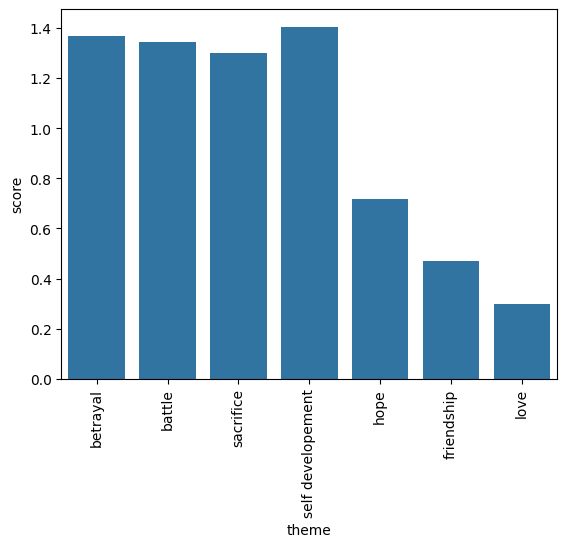

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.xticks(rotation=90)
sns.barplot(data=theme_out, x='theme', y='score')
plt.show()
